In [40]:
import pandas as pd
import numpy as np
from invertiblewavelets import Transform
import matplotlib.pyplot as plt
from invertiblewavelets import *
from scipy import signal
from scipy.interpolate import interp1d

#### Load Example Data from KPLO Spacecraft 

In [41]:
"Load Data"
data = np.load("b_kplo.npy")

'Interpolate where 0 in z axis'
mask = data[0,0] == 0
if mask.any():
    # time-axis indices
    t = np.arange(data.shape[2])

    # the “good” times where data[0,0] is non-zero
    t_good = t[~mask]

    # the corresponding data at those times for all sensors/axes
    # shape (3,3,len(t_good))
    data_good = data[:,:,~mask]

    # build an interpolator along axis=2 (the sample axis)
    f = interp1d(
        t_good,
        data_good,
        axis=2,
        kind='linear',
        bounds_error=False,
        fill_value="extrapolate"    # extrapolate at ends if needed
    )

    # evaluate the interpolator at every t—including the masked ones
    data_filled = f(t)

    # overwrite only the masked entries in-place
    data[:,:,mask] = data_filled[:,:,mask]

In [43]:
B = data[[0,2]]
sample_rate = 1

In [44]:
fb = DyadicFilterBank(wavelet=Cauchy(1000), fs=sample_rate, N=5*5000, real=True, s_max = 40, dj = 1/18)
transform = Transform(
    data=B[0],
    fs = sample_rate,
    filterbank=fb,
    pad_method='symmetric', # Padding method for the convolution calls np.pad. Set to None if no padding
)

c:\ProgramData\Anaconda3\lib\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


MemoryError: Unable to allocate 694. GiB for an array with shape (265091, 351488) and data type float64

Text(0.5, 0, 'Frequency Channel')

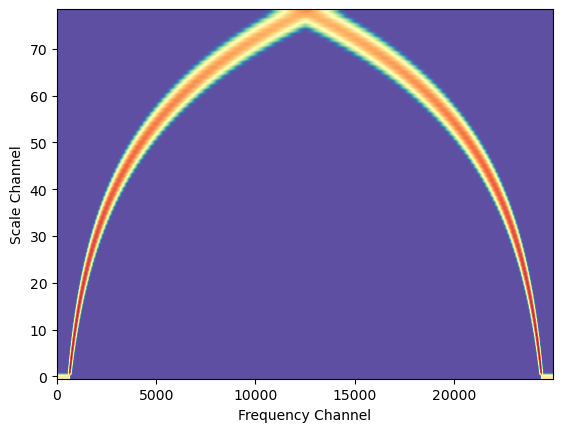

In [22]:
fig, ax = plt.subplots(1,1)
ax.imshow(np.log(np.abs(transform.Wfreq)+1e-3), aspect='auto', origin='lower', cmap='Spectral_r', interpolation=None)
ax.set_ylabel('Scale Channel')
ax.set_xlabel('Frequency Channel')

In [23]:
w1 = transform.forward(B[0])
w2 = transform.forward(B[1])

In [25]:
D = w2 - w1  # shape (J, T), complex

# 1) correlations (eqs 6–7), using conjugate inner products
C1 = np.sum( D * np.conj(w1), axis=1 )   # shape (J,)
C2 = np.sum( D * np.conj(w2), axis=1 )   # shape (J,)

# 2) gain estimate K̂ per scale (eq 8)
K_hat = C2 / C1                          # shape (J,)
# (optionally force to real if you know K is real:)
K_hat = K_hat.real

# 3) stray‑field estimate A(s,τ) (eq 9)
A = D / (K_hat[:,None] - 1)              # shape (J, T), complex

# 4) ambient‑field estimate X(s,τ) (eq 10)
X = (K_hat[:,None]*w1 - w2) / (K_hat[:,None] - 1) 

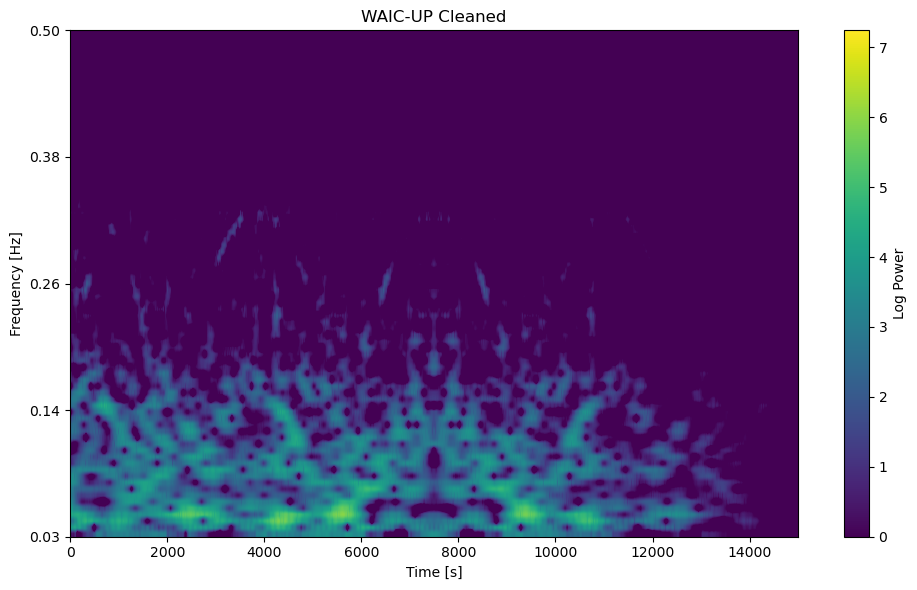

In [26]:
transform.scalogram(X, vmin=0,  title = 'WAIC-UP Cleaned')

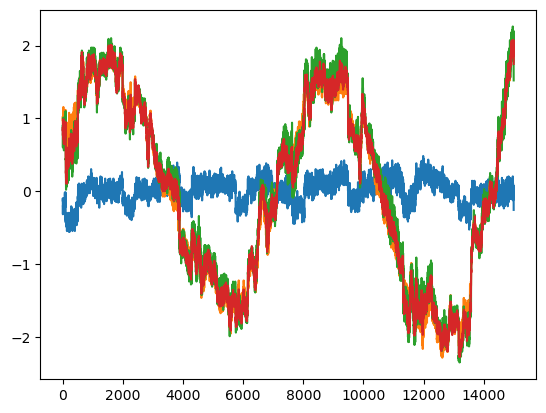

In [27]:
result = transform.inverse(np.copy(X))
plt.plot(B[1]- B[0])
plt.plot(B[0])
plt.plot(B[1])
plt.plot(result)

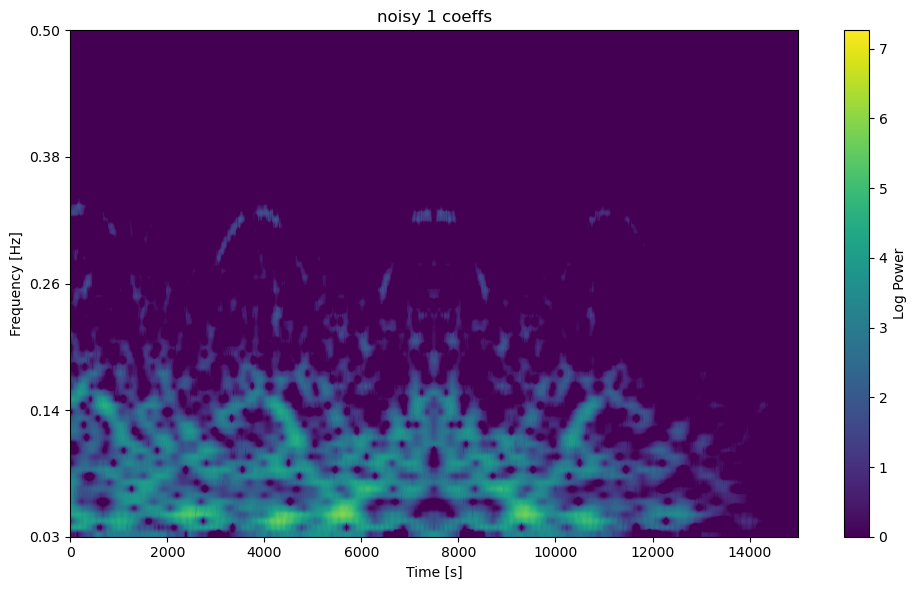

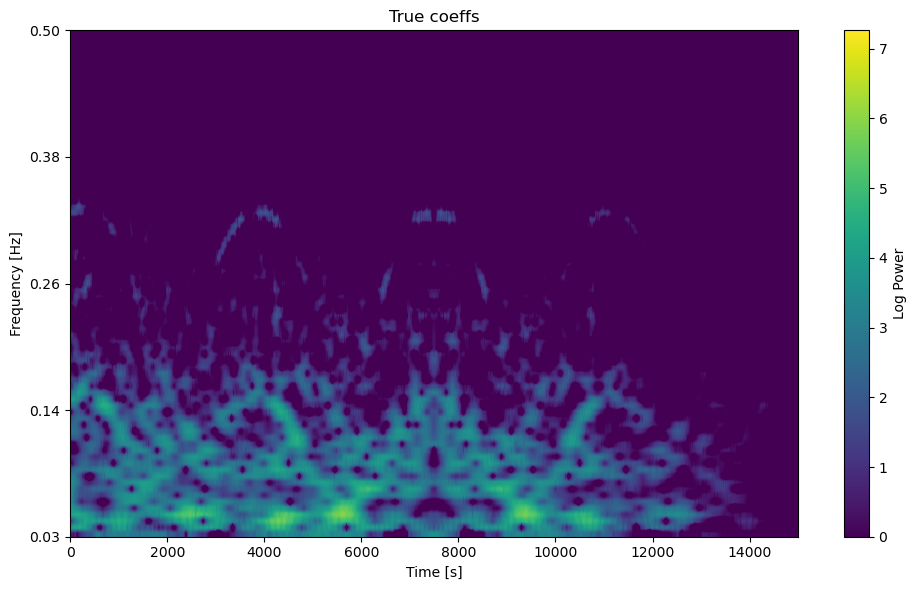

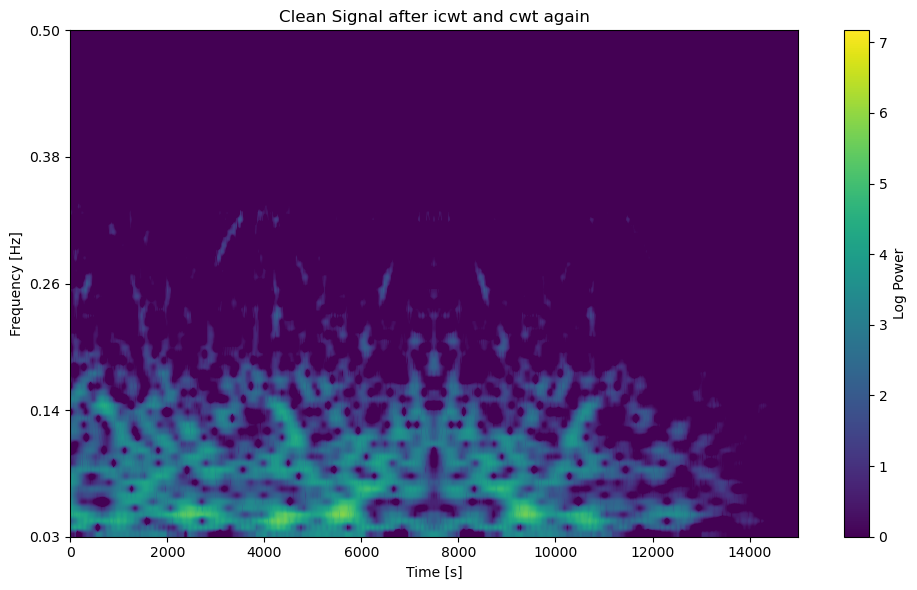

In [28]:
transform.scalogram(w1, vmin=0,  title = 'noisy 1 coeffs')
transform.scalogram(transform.forward(B[0]), vmin=0, title = 'True coeffs')
w = transform.forward(result)
transform.scalogram(w, vmin=0, title = 'Clean Signal after icwt and cwt again')

'\nThis chart shows from the frequency in the x axis from the np.fft and the wavelet channel in the y axis. The frequency uncertainty grows with scale decrease. The top panel shows the wavelet filterbank, the middle pannel shows cleaned sensor data, and the bottom panel shows the raw filterbank. It appears that the 20 Hz signal is strong outside the frequency band of the corresponding wavelet. This 20 Hz signal can be seen as a vertical stripe in the bottom panel. Why does that signal appear outside of the relevant wavelet band? \n'

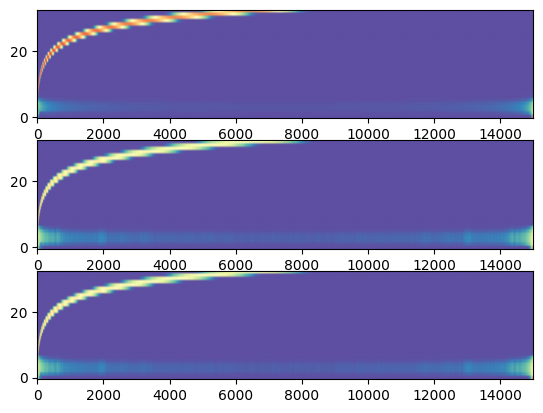

In [20]:
# https://www.sciencedirect.com/science/article/abs/pii/S0888327002915244 Aliasing??
fig, ax = plt.subplots(3,1)
ax[0].imshow(np.log(np.abs(transform.Wfreq)+1e-3), aspect='auto', origin='lower', cmap='Spectral_r')
ax[1].imshow(np.log(np.abs(np.fft.fft(w_clean, axis=1)) +1e-3), aspect='auto', origin='lower', cmap='Spectral_r')
ax[2].imshow(np.log(np.abs(np.fft.fft(w1, axis=1)) +1e-3), aspect='auto', origin='lower', cmap='Spectral_r')


"""
This chart shows from the frequency in the x axis from the np.fft and the wavelet channel in the y axis. The frequency uncertainty grows with scale decrease. The top panel shows the wavelet filterbank, the middle pannel shows cleaned sensor data, and the bottom panel shows the raw filterbank. It appears that the 20 Hz signal is strong outside the frequency band of the corresponding wavelet. This 20 Hz signal can be seen as a vertical stripe in the bottom panel. Why does that signal appear outside of the relevant wavelet band? 
"""

In [5]:
transform.b

1

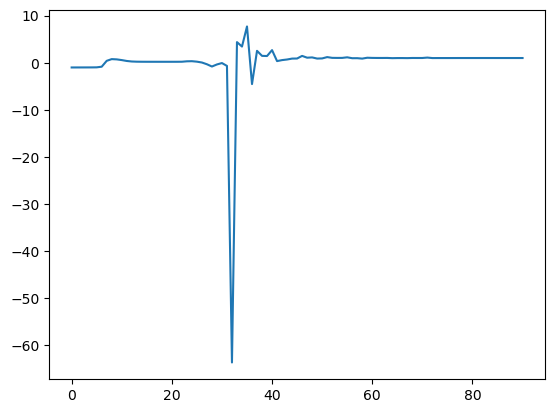

In [6]:

from wavelets import WaveletAnalysis
w1 = WaveletAnalysis(B[0], dt=1/sample_rate, frequency=True, dj = 1/8, unbias=False, mask_coi = True)
w2 = WaveletAnalysis(B[1], dt=1/sample_rate, frequency=True, dj = 1/8, unbias=False, mask_coi = True)

"Transform signals into wavelet domain"
wn1 = w1.wavelet_transform.real
wn2 = w2.wavelet_transform.real

"Sheinker and Moldwin's Algorithm"
dw = wn2-wn1
wc1 = np.sum(dw*wn1, axis=1)
wc2 = np.sum(dw*wn2, axis=1)
k_hat_real = wc2/wc1
plt.plot(k_hat_real)

#### WAICUP


(2.3926963860090864+0j)


c:\Users\aphoffm2\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\aphoffm2\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


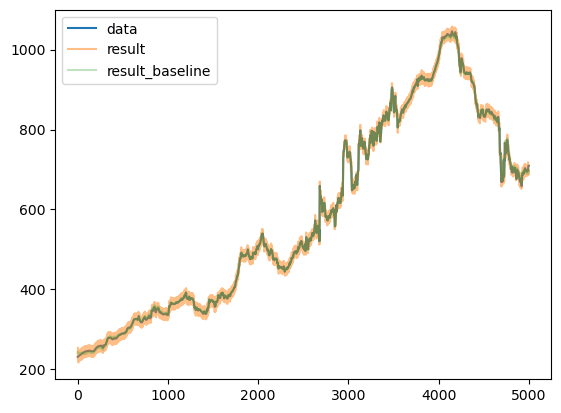

In [35]:
from magprime.algorithms import WAICUP
%matplotlib inline
WAICUP.fs = sample_rate
WAICUP.detrend =True
result_baseline = WAICUP.clean(B, triaxial=False)
print(np.sqrt(((data-result_baseline)**2).mean(axis=0)))
plt.plot(data, label='data')
plt.plot(result, label='result', alpha=0.5)
plt.plot(result_baseline, label='result_baseline', alpha=0.3)
plt.legend()

In [8]:
1/6.10351562e-03



163.84000013421775